In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from duckduckgo_search import DDGS
import numpy as np
import pandas as pd
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')
import time, json
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import PIL
import sklearn.metrics
from fastai.metrics import F1Score
import os


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames[:1]:
        print(os.path.join(dirname, filename))


/kaggle/input/buw-chest-x-ray-challange/challenge_data/submission/SUB-137.jpeg
/kaggle/input/buw-chest-x-ray-challange/challenge_data/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/buw-chest-x-ray-challange/challenge_data/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
/kaggle/input/buw-chest-x-ray-challange/challenge_data/test/PNEUMONIA/person1676_virus_2892.jpeg
/kaggle/input/buw-chest-x-ray-challange/challenge_data/test/NORMAL/NORMAL2-IM-0336-0001.jpeg
/kaggle/input/buw-chest-x-ray-challange/challenge_data/train/PNEUMONIA/person1180_virus_2010.jpeg
/kaggle/input/buw-chest-x-ray-challange/challenge_data/train/NORMAL/NORMAL2-IM-0771-0001.jpeg


In [3]:
path = {
    "train":Path('/kaggle/input/buw-chest-x-ray-challange/challenge_data/train'),
    "val": Path('/kaggle/input/buw-chest-x-ray-challange/challenge_data/val') ,
    "test": Path('/kaggle/input/buw-chest-x-ray-challange/challenge_data/test'),
    "submission": Path('/kaggle/input/buw-chest-x-ray-challange/challenge_data/submission')
}

In [4]:
batch_tfms=batch_tfms = aug_transforms(
    flip_vert=True,  # Vertikale Spiegelung
    max_rotate=10,   # Zufällige Rotation bis 10 Grad
    # max_zoom=1.2,    # Zufälliger Zoom bis 1.2x
    max_warp=0.2,    # Verzerrung
    # min_scale=0.8,   # Zufälliges Skalieren (bis 80 % der Originalgröße)
    size=256
)


def custom_tfms(x: TensorImage):
    arr = x.numpy()  # Konvertiere Tensor in NumPy-Array
    arr = np.where(arr>np.mean(arr),0,arr)  # Setze Werte unter 0.5 auf 0 (bei normalisierten Bildern)
    return TensorImage(torch.tensor(arr))  # Konvertiere zurück in TensorImage

item_tfms = [custom_tfms]

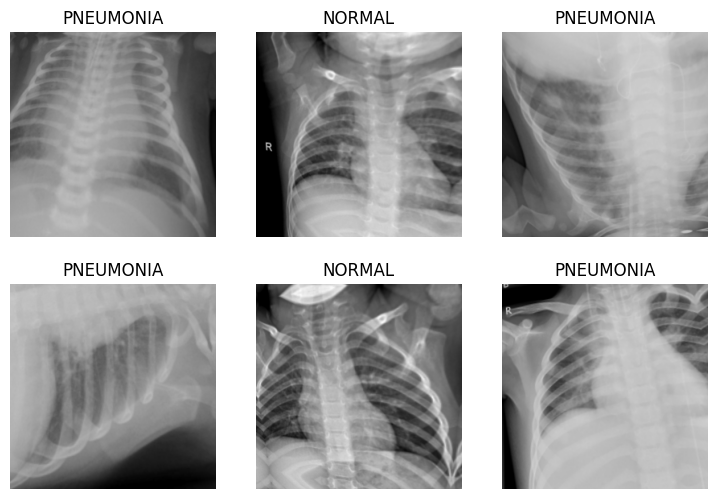

In [5]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[custom_tfms, Resize(224)],
    batch_tfms=batch_tfms
).dataloaders(path['train'], bs=32)

dls.show_batch(max_n=6)

In [6]:
learn = vision_learner(dls, resnet152, metrics=F1Score())
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:01<00:00, 237MB/s]


epoch,train_loss,valid_loss,f1_score,time
0,0.542633,0.261760,0.946368,01:04


epoch,train_loss,valid_loss,f1_score,time
0,0.280782,0.171816,0.967957,01:19
1,0.189542,0.092514,0.980883,01:19
2,0.139690,0.130491,0.971276,01:19


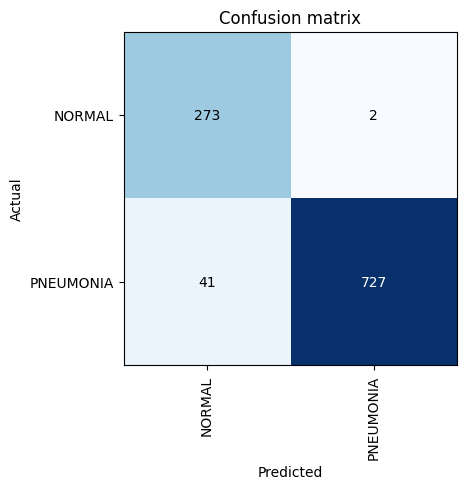

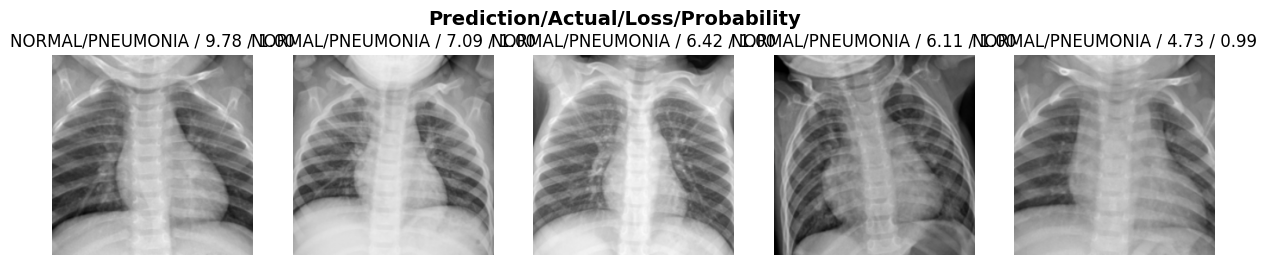

In [7]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

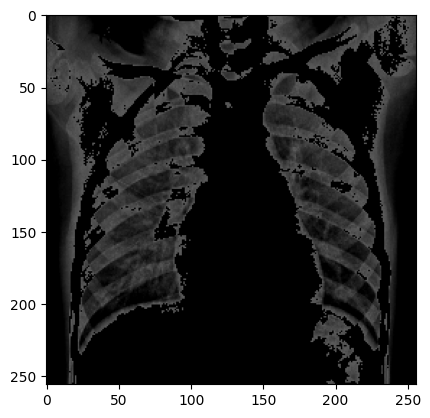

In [8]:

impaths = []
files = os.listdir(path['val']/'NORMAL')
for i in files:
    impaths.append(path['val']/'NORMAL'/i)
# img = plt.imread(impaths[1])
img = PILImage.create(impaths[1])
img = np.array(img, copy=True)
img = cv2.resize(img,(256,256))
img = np.where(img>np.mean(img),0,img)
plt.imshow(img)


In [9]:
# for i in impaths:
#     img = plt.imread(i)
#     img = np.array(img, copy=True)
#     img = cv2.resize(img,(256,256))
#     print(learn.predict(img))

In [10]:
# for i in impaths:
#     which_flower,idx,probs = learn.predict(PILImage.create(i))
#     print(f"This is a: {which_flower}.")
#     print(f"Probability is {probs[idx]:.4f}")

In [11]:
from fastai.vision.all import *  # Importiert alle wichtigen Funktionen für die Bildverarbeitung aus fastai
import sklearn
val_path = Path('/kaggle/input/buw-chest-x-ray-challange/challenge_data/test')

val_files = get_image_files(val_path)

val_dl = dls.test_dl(val_files, with_labels=True)

preds, targets = learn.get_preds(dl=val_dl)


correct = (preds.argmax(dim=1) == targets).sum().item()
print(correct)
total = len(targets)

accuracy = correct / total

print(f"Anzahl richtiger Vorhersagen: {correct}")
print(f"Anzahl falscher Vorhersagen: {total - correct}")
print(f"Genauigkeit: {accuracy:.4f}")

276
Anzahl richtiger Vorhersagen: 276
Anzahl falscher Vorhersagen: 36
Genauigkeit: 0.8846


In [12]:
# print(preds)
print(preds.argmax(dim=1))
print(targets)

sklearn.metrics.f1_score(y_true=targets,y_pred=preds.argmax(dim=1))

tensor([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

0.9146919431279621

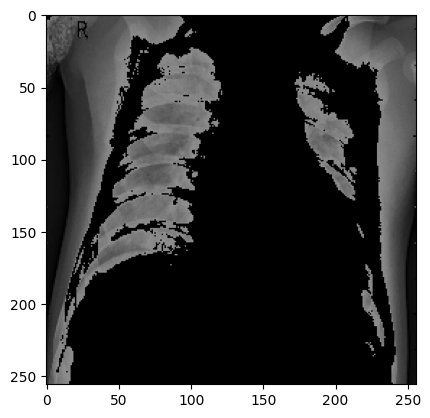

In [13]:

impaths = []
files = os.listdir(path['submission'])
for i in files:
    impaths.append(path['submission']/i)
# img = plt.imread(impaths[1])
img = PILImage.create(impaths[1])
img = np.array(img, copy=True)
img = cv2.resize(img,(256,256))
img = np.where(img>np.mean(img),0,img)
plt.imshow(img)


In [14]:
sub_path = path['submission']

sub_files = get_image_files(sub_path)

sub_dl = dls.test_dl(sub_files, with_labels=False)

preds_sub = learn.get_preds(dl=sub_dl)

preds_sub = preds_sub[0]

preds_fin  = preds_sub.argmax(dim=1).tolist()

print()

In [15]:
 filenames = [x.name for x in sub_files]

In [16]:
submission = {
    "ID" :filenames ,
    "Label" : preds_fin
}
df  = pd.DataFrame(submission)
df  =df.sort_values(by="ID", ascending=True)

df.head()
df.to_csv('submission.csv',index=0)